In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")

In [3]:
train['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN

data = pd.concat([train, test])

%matplotlib inline

data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train_test   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.0
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.0
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.0
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.0
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.0
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.0
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.0
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.0


In [6]:
train.describe().columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'train_test'],
      dtype='object')

In [7]:
# numeric values
df_num = train[['Age', 'SibSp', 'Parch', 'Fare']]

# categorical values
df_cat = train[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

# Feature Engineering

1) Cabin - Simplify cabins (evaluated if cabin letter (cabin_adv) or the purchase of tickets across multiple cabins (cabin_multiple) impacted survival)

2) Tickets - Do different ticket types impact survival rates?

3) Does a person's title relate to survival rates?

**Simplify Cabins**

In [8]:
df_cat.Cabin
train['cabin_multiple'] = train.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
train['cabin_multiple'].value_counts()

0    687
1    180
2     16
3      6
4      2
Name: cabin_multiple, dtype: int64

In [9]:
pd.pivot_table(train, index = 'Survived', columns = 'cabin_multiple', values = 'Ticket' ,aggfunc ='count')

cabin_multiple,0,1,2,3,4
Survived,,,,,
0,481.0,58.0,7.0,3.0,NaN
1,206.0,122.0,9.0,3.0,2.0


In [10]:
train['cabin_adv'] = train.Cabin.apply(lambda x: str(x)[0])

**Ticket Value**

In [11]:
#understand ticket values better 
#numeric vs non numeric 
train['numeric_ticket'] = train.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
train['ticket_letters'] = train.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)

train['numeric_ticket'].value_counts()

1    661
0    230
Name: numeric_ticket, dtype: int64

In [12]:
#lets us view all rows in dataframe through scrolling. This is for convenience 
pd.set_option("max_rows", None)
train['ticket_letters'].value_counts()

0            665
pc            60
ca            41
a5            21
stono2        18
sotonoq       15
scparis       11
wc            10
a4             7
soc            6
fcc            5
c              5
sopp           3
pp             3
wep            3
ppp            2
scah           2
sotono2        2
swpp           2
fc             1
scahbasle      1
as             1
sp             1
sc             1
scow           1
fa             1
sop            1
sca4           1
casoton        1
Name: ticket_letters, dtype: int64

In [13]:
#difference in numeric vs non-numeric tickets in survival rate 
pd.pivot_table(train,index='Survived',columns='numeric_ticket', values = 'Ticket', aggfunc='count')

numeric_ticket,0,1
Survived,,
0,142,407
1,88,254


In [14]:
#survival rate across different tyicket types 
pd.pivot_table(train,index='Survived',columns='ticket_letters', values = 'Ticket', aggfunc='count')

ticket_letters,0,a4,a5,as,c,ca,casoton,fa,fc,fcc,...,soc,sop,sopp,sotono2,sotonoq,sp,stono2,swpp,wc,wep
Survived,,,,,,,,,,,,,,,,,,,,,
0,410.0,7.0,19.0,1.0,3.0,27.0,1.0,1.0,1.0,1.0,...,5.0,1.0,3.0,2.0,13.0,1.0,10.0,NaN,9.0,2.0
1,255.0,NaN,2.0,NaN,2.0,14.0,NaN,NaN,NaN,4.0,...,1.0,NaN,NaN,NaN,2.0,NaN,8.0,2.0,1.0,1.0


In [15]:
#feature engineering on person's title 
train.Name.head(50)
train['name_title'] = train.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
#mr., ms., master. etc

train['name_title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: name_title, dtype: int64

# Data Processing

(889,)

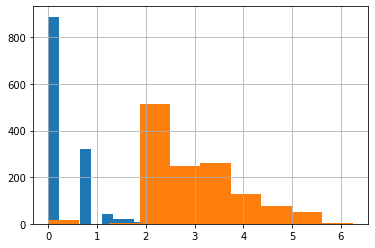

In [16]:
#create all categorical variables that we did above for both training and test sets 
data['cabin_multiple'] = data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
data['cabin_adv'] = data.Cabin.apply(lambda x: str(x)[0])
data['numeric_ticket'] = data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
data['ticket_letters'] = data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)
data['name_title'] = data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

#drop null 'embarked' rows. Only 2 instances of this in training and 0 in test 
data.dropna(subset=['Embarked'],inplace = True)

#impute nulls for continuous data 
original_age = data.Age # Store the orignal age to try EM
# data.Age = data.Age.fillna(train.Age.median())
original_fare = data.Fare
# data.Fare = data.Fare.fillna(train.Fare.median())

#tried log norm of sibsp (not used)
data['norm_sibsp'] = np.log(data.SibSp+1)
data['norm_sibsp'].hist()

# log norm of fare (used)
data['norm_fare'] = np.log(data.Fare+1)
data['norm_fare'].hist()

# converted fare to category for pd.get_dummies()
data.Pclass = data.Pclass.astype(str)

#created dummy variables from categories (also can use OneHotEncoder)
all_dummies = pd.get_dummies(data[['Pclass','Sex','Age','SibSp','Parch','norm_fare','Embarked','cabin_adv','cabin_multiple','numeric_ticket','name_title','train_test']])

#Split to train test again
X_train = all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis =1)
X_test = all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis =1)

y_train = data[data.train_test==1].Survived
y_train.shape

# Modeling

In [17]:
# Scale data 
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age','SibSp','Parch','norm_fare']]= scale.fit_transform(all_dummies_scaled[['Age','SibSp','Parch','norm_fare']])
all_dummies_scaled

X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = data[data.train_test==1].Survived

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.experimental    import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

**Historgram Gradient Boosting without imputation**

In [19]:
hgb = HistGradientBoostingClassifier()
cv = cross_val_score(hgb,X_train_scaled,y_train,cv=5)
print(cv)
print(f'{cv.mean()} +/-{cv.std():.2f}')

[0.80337079 0.8258427  0.88202247 0.80898876 0.84180791]
0.8324065257411288 +/-0.03


**Historgram Gradient Boosting with median imputation**

In [20]:
# Impute the data with the median
data.Age = data.Age.fillna(train.Age.median())
data.Fare = data.Fare.fillna(train.Fare.median())
all_dummies = pd.get_dummies(data[['Pclass','Sex','Age','SibSp','Parch','norm_fare','Embarked','cabin_adv','cabin_multiple','numeric_ticket','name_title','train_test']])

all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age','SibSp','Parch','norm_fare']]= scale.fit_transform(all_dummies_scaled[['Age','SibSp','Parch','norm_fare']])
all_dummies_scaled

X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = data[data.train_test==1].Survived

In [21]:
hgb = HistGradientBoostingClassifier()
cv = cross_val_score(hgb, X_train_scaled, y_train,cv=5)
print(cv)
print(f'{cv.mean()} +/-{cv.std():.2f}')

[0.80898876 0.8258427  0.87640449 0.8258427  0.84180791]
0.8357773122579826 +/-0.02


**Historgram Gradient Boosting with E.M.**

In [22]:
data.select_dtypes(include=np.number).corrwith(original_age)

PassengerId       0.028788
Survived         -0.082446
Age               1.000000
SibSp            -0.242910
Parch            -0.149992
Fare              0.175994
train_test       -0.020413
cabin_multiple    0.230832
numeric_ticket   -0.027412
norm_sibsp       -0.197750
norm_fare         0.191787
dtype: float64

In [23]:
original_age.shape

(1307,)

In [24]:
data.select_dtypes(include=np.number).shape

(1307, 11)

In [25]:
data.shape

(1307, 20)

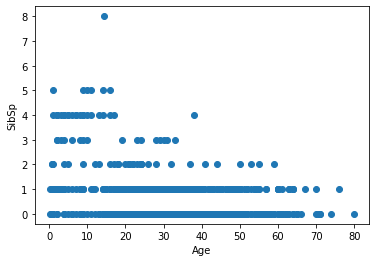

In [26]:
plt.scatter(original_age, data['SibSp'])
plt.xlabel('Age')
plt.ylabel('SibSp');

The feature SibSp represents whether a person is alone or with his family members.

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife

In [27]:
pd.crosstab([data.SibSp],data.Survived).style.background_gradient(cmap='summer_r')

Survived,0.0,1.0
SibSp,,
0,398,208
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='SibSp', ylabel='Age'>

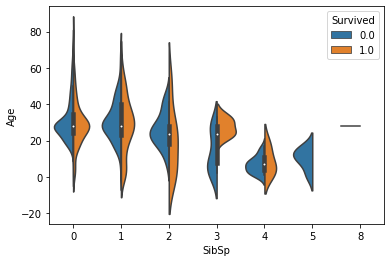

In [28]:
sns.violinplot("SibSp","Age", hue="Survived", data=data,split=True)

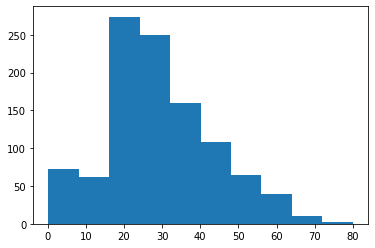

In [29]:
plt.hist(original_age);

In [30]:
# How many ages must be imputed
np.isnan(original_age).sum()

263

In [31]:
# E.M. based on https://github.com/eltonlaw/impyute/blob/master/impyute/imputation/cs/em.py
eps=0.1
original_age.reset_index(drop=True, inplace=True)
nan_row = original_age[np.isnan(original_age)].index
em_age = original_age.copy().values
for x_i in nan_row:
    previous = 1
    for i in range(5):
        # Expectation
        mu = em_age[~np.isnan(em_age)].mean()
        std = em_age[~np.isnan(em_age)].std()
        # Maximization
        em_age[x_i] = np.clip(np.random.normal(loc=mu, scale=std), em_age.min(), em_age.max())
        # Break out of loop if likelihood doesn't change at least 10%
        delta = np.abs(em_age[x_i]-previous)/previous
        if i and (delta < eps):
            break
        previous = em_age[x_i]
    print (f'Imputed {x_i} with {em_age[x_i]}')

Imputed 5 with 31.185576679145637
Imputed 17 with 29.54067770692749
Imputed 19 with 25.986568272297333
Imputed 26 with 37.13902760696867
Imputed 28 with 45.41507234405356
Imputed 29 with -6.4466986411395375
Imputed 31 with 35.722340607739525
Imputed 32 with 27.230839937699926
Imputed 36 with 40.11363666081169
Imputed 42 with 37.23236338072275
Imputed 45 with 36.776438161063986
Imputed 46 with 8.751429620207816
Imputed 47 with 27.318007871784573
Imputed 48 with 17.931632267153567
Imputed 55 with 49.31453226823678
Imputed 63 with 20.15110191621899
Imputed 64 with 28.7432880505018
Imputed 75 with 19.301410125770655
Imputed 76 with 38.51970096632473
Imputed 81 with 32.09640680786296
Imputed 86 with 35.10542516131237
Imputed 94 with 31.31516583604845
Imputed 100 with 29.27294767685339
Imputed 106 with 29.951871453626847
Imputed 108 with 45.74042151426399
Imputed 120 with 44.488426453597874
Imputed 125 with 48.24628585683552
Imputed 127 with 36.759210924487064
Imputed 139 with 36.25629867537

In [32]:
pd.Series(em_age).describe()

count    1307.000000
mean       30.020978
std        14.035532
min        -9.478260
25%        21.000000
50%        29.000000
75%        38.563925
max        80.000000
dtype: float64

In [33]:
original_age.dropna().describe()

count    1044.000000
mean       29.842596
std        14.390739
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

In [34]:
np.isnan(original_age).sum()

263

**Histrogram Gradient Boosting after E.M.**

In [35]:
# Impute the data with the median
data.Age = em_age
all_dummies = pd.get_dummies(data[['Pclass','Sex','Age','SibSp','Parch','norm_fare','Embarked','cabin_adv','cabin_multiple','numeric_ticket','name_title','train_test']])

all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age','SibSp','Parch','norm_fare']]= scale.fit_transform(all_dummies_scaled[['Age','SibSp','Parch','norm_fare']])
all_dummies_scaled

X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = data[data.train_test==1].Survived

In [36]:
hgb = HistGradientBoostingClassifier()
cv = cross_val_score(hgb, X_train_scaled, y_train,cv=5)
print(cv)
print(f'{cv.mean()} +/-{cv.std():.2f}')

[0.78089888 0.80337079 0.85955056 0.80337079 0.87570621]
0.8245794451850441 +/-0.04


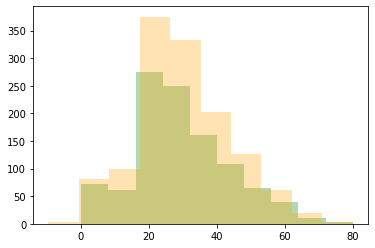

In [37]:
plt.hist(original_age, alpha=0.3, color='green')
plt.hist(em_age, alpha=0.3, color='orange');

**EM based on Fisk distribution**

In [38]:
from scipy.stats import norm, lognorm, normaltest, fisk, burr

In [39]:
# Age data is not normal distributed
normal_data = original_age[~np.isnan(original_age)]
print('normaltest teststat = %6.3f pvalue = %6.4f' %
      normaltest((normal_data-normal_data.mean())/normal_data.std()))

normaltest teststat = 28.180 pvalue = 0.0000


In [40]:
# Lets fit the 
fisk.fit(original_age[~np.isnan(original_age)])

(10.576534289959959, -55.85940918081563, 84.50719834774009)

In [41]:
eps=0.1
original_age.reset_index(drop=True, inplace=True)
nan_row = original_age[np.isnan(original_age)].index
em_age = original_age.copy().values
for x_i in nan_row:
    previous = 1
    for i in range(5):
        # Expectation
        fitting_params = fisk.fit(em_age[~np.isnan(em_age)])
        # Maximization
        em_age[x_i] = np.clip(fisk(*fitting_params).rvs(size=1), original_age.min(), original_age.max())
        # Break out of loop if likelihood doesn't change at least 10%
        delta = np.abs(em_age[x_i]-previous)/previous
        if i and (delta < eps):
            break
        previous = em_age[x_i]
    print (f'Imputed {x_i} with {em_age[x_i]}')

Imputed 5 with 21.904894726193454
Imputed 17 with 35.224959523660615
Imputed 19 with 27.532748296734113
Imputed 26 with 17.697004918840577
Imputed 28 with 22.747812928478865
Imputed 29 with 20.13479050563508
Imputed 31 with 44.36993221175295
Imputed 32 with 33.10964595035121
Imputed 36 with 33.647652555916046
Imputed 42 with 45.95961799146137
Imputed 45 with 18.525807301239382
Imputed 46 with 58.18891931933875
Imputed 47 with 43.0474386128635
Imputed 48 with 24.97043428851204
Imputed 55 with 27.320106086705707
Imputed 63 with 31.756907368513026
Imputed 64 with 33.51219988364605
Imputed 75 with 32.23233750988935
Imputed 76 with 36.695807751150895
Imputed 81 with 21.635005766790968
Imputed 86 with 32.13662727274155
Imputed 94 with 40.13764309940435
Imputed 100 with 37.28081878975408
Imputed 106 with 32.23168531399827
Imputed 108 with 27.473289005429194
Imputed 120 with 19.907539222704656
Imputed 125 with 23.587583328703182
Imputed 127 with 27.2909312852899
Imputed 139 with 18.65810233514

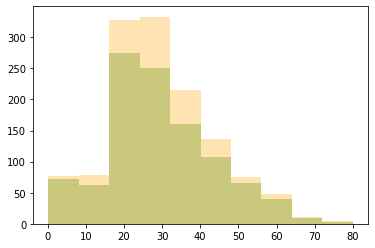

In [42]:
plt.hist(original_age, alpha=0.3, color='green')
plt.hist(em_age, alpha=0.3, color='orange');

In [43]:
# Impute the data with the median
data.Age = em_age
all_dummies = pd.get_dummies(data[['Pclass','Sex','Age','SibSp','Parch','norm_fare','Embarked','cabin_adv','cabin_multiple','numeric_ticket','name_title','train_test']])

all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age','SibSp','Parch','norm_fare']]= scale.fit_transform(all_dummies_scaled[['Age','SibSp','Parch','norm_fare']])
all_dummies_scaled

X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = data[data.train_test==1].Survived

In [44]:
hgb = HistGradientBoostingClassifier()
cv = cross_val_score(hgb, X_train_scaled, y_train,cv=5)
print(cv)
print(f'{cv.mean()} +/-{cv.std():.2f}')

[0.78651685 0.80337079 0.84831461 0.80337079 0.83615819]
0.8155462451596522 +/-0.02


# Burr disribution

In [45]:
# Lets fit the 
burr.fit(original_age[~np.isnan(original_age)])

(6.213245028277331, 0.4999456314550324, -9.623269105027845, 45.78790730981197)

In [46]:
eps=0.1
nan_row = original_age[np.isnan(original_age)].index
em_age = original_age.copy().values
for x_i in nan_row:
    previous = 1
    for i in range(5):
        # Expectation
        fitting_params = burr.fit(em_age[~np.isnan(em_age)])
        # Maximization
        em_age[x_i] = np.clip(burr(*fitting_params).rvs(size=1), original_age.min(), original_age.max())
        # Break out of loop if likelihood doesn't change at least 10%
        delta = np.abs(em_age[x_i]-previous)/previous
        if i and (delta < eps):
            break
        previous = em_age[x_i]
    print (f'Imputed {x_i} with {em_age[x_i]}')

Imputed 5 with 11.786088257407435
Imputed 17 with 30.56570361644795
Imputed 19 with 41.62619214010155
Imputed 26 with 26.751801845507202
Imputed 28 with 30.486324433990923
Imputed 29 with 57.180744811594586
Imputed 31 with 38.665146220696094
Imputed 32 with 25.290970919236802
Imputed 36 with 28.31123731477715
Imputed 42 with 20.07075189895459
Imputed 45 with 77.5277749671423
Imputed 46 with 35.28236088160456
Imputed 47 with 80.0
Imputed 48 with 35.204349684776915
Imputed 55 with 24.639643525298514
Imputed 63 with 27.542909466594292
Imputed 64 with 21.193445119528878
Imputed 75 with 23.58387659683719
Imputed 76 with 35.94762957031364
Imputed 81 with 29.174803398538824
Imputed 86 with 64.21161651298928
Imputed 94 with 41.18626315752018
Imputed 100 with 31.877996485200267
Imputed 106 with 5.942309291668003
Imputed 108 with 23.494592776279
Imputed 120 with 0.17
Imputed 125 with 27.512721225639385
Imputed 127 with 23.796830550141422
Imputed 139 with 30.87815998795113
Imputed 153 with 12.712

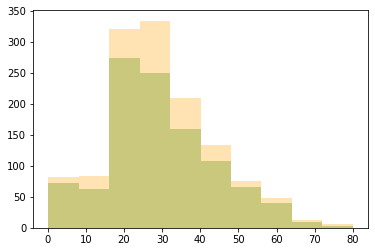

In [47]:
plt.hist(original_age, alpha=0.3, color='green')
plt.hist(em_age, alpha=0.3, color='orange');

In [48]:
# Impute the data with the median
data.Age = em_age
all_dummies = pd.get_dummies(data[['Pclass','Sex','Age','SibSp','Parch','norm_fare','Embarked','cabin_adv','cabin_multiple','numeric_ticket','name_title','train_test']])

all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age','SibSp','Parch','norm_fare']]= scale.fit_transform(all_dummies_scaled[['Age','SibSp','Parch','norm_fare']])
all_dummies_scaled

X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = data[data.train_test==1].Survived

In [49]:
hgb = HistGradientBoostingClassifier()
cv = cross_val_score(hgb, X_train_scaled, y_train, cv=5)
print(cv)
print(f'{cv.mean()} +/-{cv.std():.2f}')

[0.7752809  0.79775281 0.84831461 0.81460674 0.85310734]
0.8178124801625086 +/-0.03
